In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from umap import UMAP

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
companies = pd.read_csv('../data/01 - cleaned/companies_cleaned.csv')

# Clustering

Dado que el fin último es poder comparar el posicionamiento de una empresa respecto a sus competidores directos, se propone armar clusters para que, cuando el usuario elija una, se representen las características de todas las que operan en un mercado similar al de la seleccionada.

El clustering se enfoca en los servicios que las empresas ofrecen (`service focus`) y el tamaño de los clientes juntos a los que trabajan (`client focus`).

In [4]:
columns_clustering = [
    columna for columna in companies.columns 
    if columna.startswith("service_") or columna.startswith("client_focus_")
]

In [5]:
columns_clustering

['client_focus_enterprise_1b',
 'client_focus_midmarket_10m_1b',
 'client_focus_small_business_10m',
 'service_focus_custom_software_development',
 'service_focus_digital_strategy',
 'service_focus_ecommerce_development',
 'service_focus_it_managed_services',
 'service_focus_it_staff_augmentation',
 'service_focus_it_strategy_consulting',
 'service_focus_mobile_app_development',
 'service_focus_search_engine_optimization',
 'service_focus_social_media_marketing',
 'service_focus_uxui_design',
 'service_focus_web_design',
 'service_focus_web_development']

Se estandarizan las columnas.

In [6]:
ss = StandardScaler()
x = companies[columns_clustering]
x = ss.fit_transform(x)

Se aplica una reducción de dimesionalidad. 

En este caso, se usa la técnica UMAP. Este algoritmo es similar a TSNE pero superándolo en eficiencia.

In [7]:
umap = UMAP(n_components=4, random_state=42)
x_reduced = umap.fit_transform(x)
df_reduced = pd.DataFrame(x_reduced)

Se grafican las 4 componentes.

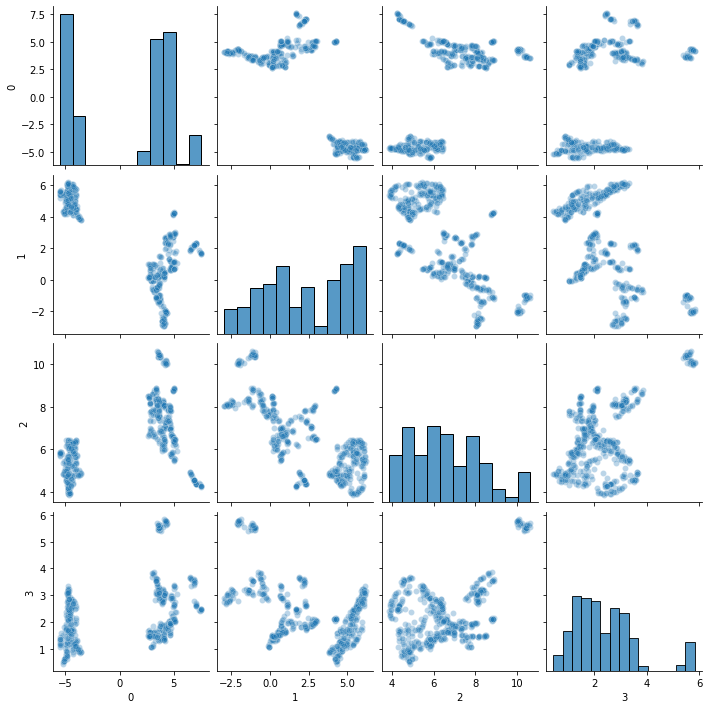

In [8]:
sns.pairplot(df_reduced, kind='scatter', plot_kws={'alpha':0.3})
plt.show()

Después una revisión gráfica, se concluye buscar 3 clusters dentro de las 4 componentes.

In [9]:
clustering_model = KMeans(n_clusters=3, random_state=42)
df_reduced['cluster'] = clustering_model.fit_predict(df_reduced)

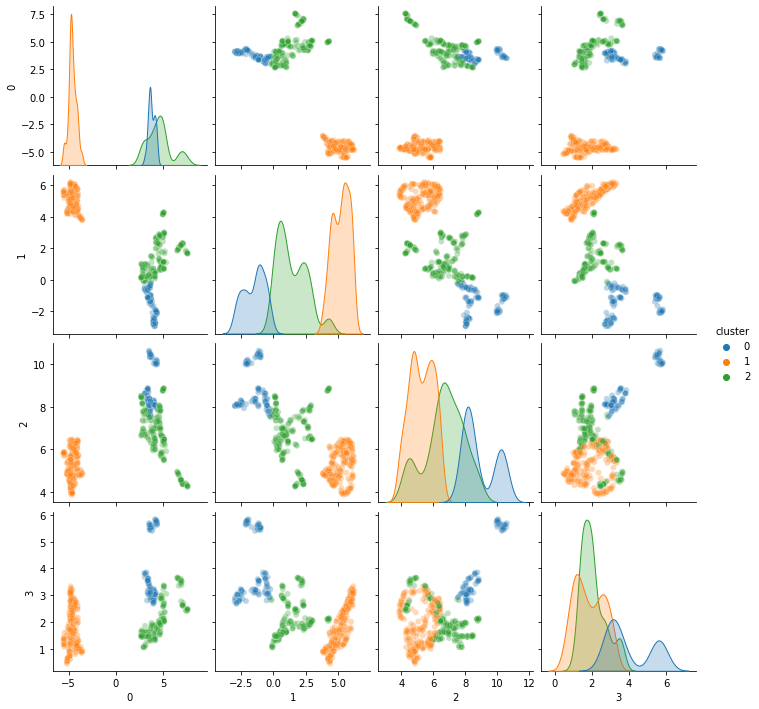

In [10]:
sns.pairplot(df_reduced, hue="cluster", kind='scatter', plot_kws={'alpha':0.3}, palette="tab10")
plt.show()

Resulta interesante ver que el cluster 1 esta bastante alejado del resto en la mayoria de las componentes.

In [11]:
model = Pipeline(steps=[
    ("standard_scaler", ss),
    ("umap", umap),
    ("clustering", clustering_model)
])

Se predice el cluster para todo el dataset utilizando el pipeline creado. Cada empresa es asignada a un grupo, donde los integrantes comparten características de servicio y mercado comunes.

In [12]:
companies["cluster"] = model.predict(companies[columns_clustering])

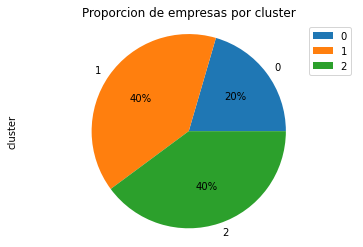

In [13]:
(
    companies
    .cluster
    .value_counts(normalize=True)
    .sort_index()
).plot.pie(legend=True, autopct=lambda x: f"{x:.0f}%")

plt.title("Proporción de empresas por cluster")
plt.axis('equal')
plt.show()

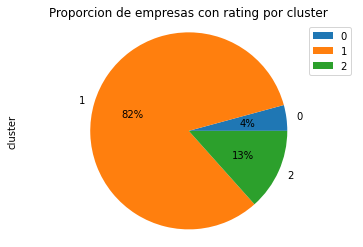

In [14]:
(
    companies
    .query("rating != 0")
    .cluster
    .value_counts(normalize=True)
    .sort_index()
).plot.pie(legend=True, autopct=lambda x: f"{x:.0f}%")

plt.title("Proporción de empresas con rating por cluster")
plt.axis('equal')
plt.show()

Se almacena el resultado para construir los índices de comparación.

In [15]:
companies.to_csv('../data/02 - processed/companies_processed.csv', index=False)